# Introduction
Cluster algorithms for $CP^{N-1}$ models with $N > 2$ have been notoriously difficult to find. For $N = 2$, the $CP^{N-1} = O(3)$ model has a natural cluster algorithm based on the specific spherical geometry of this manifold. This notebook investigates a proposal for a universal $CP^{N-1}$ cluster algorithm.

A general argument by Uwe-Jens Wiese and collaborators demonstrates that simple isometries with fixed point sets of codimension 1 exist only for $N = 2$. This is expected to be necessary for such isometries to generate cluster algorithms that effectively divide the space into independent clusters with sizes given by the correlation length of the system.

On the other hand, one might imagine that cluster algorithms may be possible to construct that appropriately mix the topology and are _not_ isometries. In this case, cluster flips would require some acceptance probabilities. This may work well if the transformation does perserve small distances nearly exactly, as these are the relevant terms appearing in the action for a typical configuration near the continuum limit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.append('../heatbath_py')
from lib import cpn, cpn_heatbath

# Proposal 1: Gauge-equivariant involution
Consider, for concreteness, the $CP^{2}$ model with field variables
$$ z = (z_1, z_2, z_3), \; |z|^2 = 1$$
Ideally, we would like to propose an involution like $z_3 \mapsto z_3^*$, but this is a gauge-dependent concept. The gauge-equivariant version of the same would involve fixing the overall $U(1)$ phase as a function of the variables $z_1$ and $z_2$, then applying this operation, and finally unfixing the gauge. Since the variables defining the gauge fixing scheme are not modified, this is a manifestly invertible operation.

How should we choose to fix the overall phase? A natural choice, extending the cluster algorithm from $CP^{1}$, would be to set $z_1$ and $z_2$ as close to positive real as possible. Of course, the two variables will in general have a relative phase between them, so we are instead asking for some kind of average overall phase to be zero. Let's define the collective variable
$$
w \equiv z_1 + z_2
$$
To remove the overall phase, we multiply the original vector by $w^* / |w|$, where
$$
|w| = \sqrt{|z_1|^2 + |z_2|^2 + 2 \mathrm{Re} z_1 z_2}
$$
After conjugation, we should remove the phase, to result in an equivariant operation. Finally, we have the generic map
$$
z_3 \mapsto z_3^* \frac{w^2}{|w|^2} = z_3^* \frac{(z_1 + z_2)^2}{\sqrt{|z_1|^2 + |z_2|^2 + 2 \mathrm{Re} z_1 z_2}}
$$
The function $w^2 / |w|^2$ has an ill-defined complex phase in the limit $w \rightarrow 0$. However, in this limit, the phase ambiguity becomes a pure-gauge effect, meaning that the limiting operation is still well-defined and continuous over the $CP^{2}$ manifold.

In [3]:
def random_cpn(size, *, Nc):
    z = np.random.normal(size=(size,Nc)) + 1j*np.random.normal(size=(size,Nc))
    z /= np.sqrt(np.sum(np.abs(z)**2, axis=-1, keepdims=True))
    return z
def apply_involution(z):
    w = np.sum(z[...,:-1], axis=-1)
    zp = np.copy(z)
    zp[...,-1] = np.conj(zp[...,-1]) * w**2 / np.abs(w)**2
    assert np.allclose(np.sum(np.abs(zp)**2, axis=-1), 1.0)
    return zp
def sample_distances(size, *, Nc):
    z1, z2 = random_cpn(2*size, Nc=Nc).reshape(2, size, Nc)
    dz12 = np.abs(np.sum(np.conj(z1) * z2, axis=-1))**2
    z1p, z2p = apply_involution(z1), apply_involution(z2)
    assert np.allclose(z1, apply_involution(z1p))
    dz12p = np.abs(np.sum(np.conj(z1p) * z2p, axis=-1))**2
    return np.stack((dz12, dz12p))

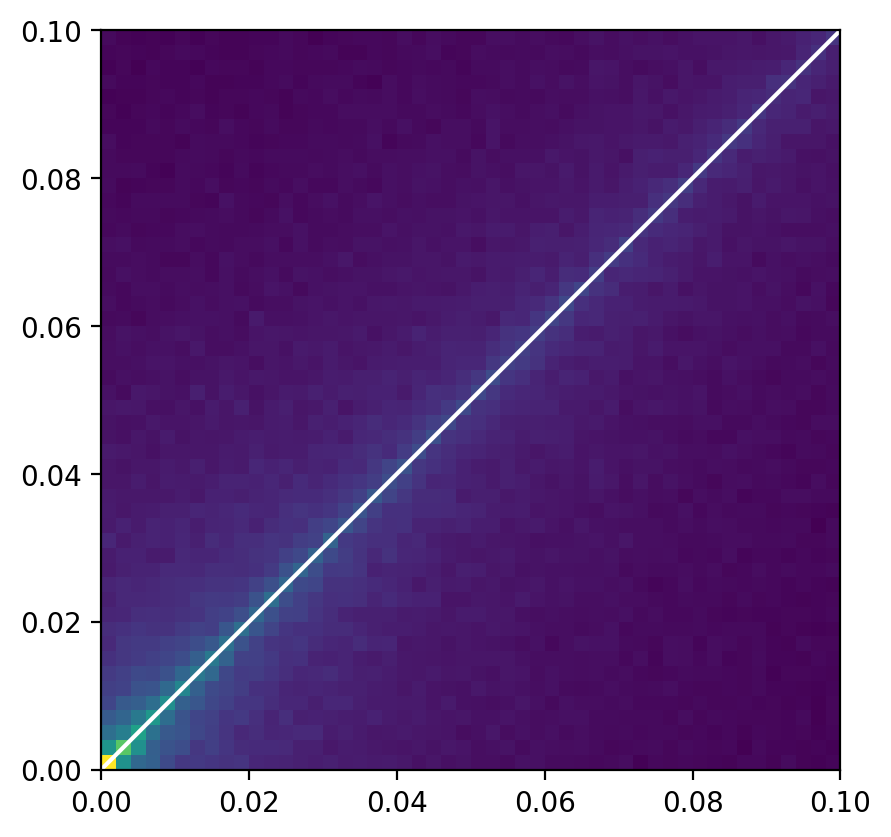

In [4]:
xs, ys = sample_distances(1000000, Nc=5)
fig, ax = plt.subplots(1,1)
bins = np.linspace(0, 0.1, num=51, endpoint=True)
ax.hist2d(xs, ys, bins=bins)
ax.set_aspect(1.0)
ax.plot([0, 1], [0, 1], linestyle='-', color='w')
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)
plt.show()

Clearly, the transformation does approximately preserve distances, but in no limit is it exact. This is unsurprising: if the distances were preserved to first order in small deformations, then all distances must be preserved by integration. Nonetheless, the fact that these distances correlate well suggests that this transformation *could* be used for an Ising spin embedding.

Consider the four possible configurations of spins on a link
$$
c_A = (z, z'), \; c_B = (f(z), f(z')), \; c_C = (f(z), z'), \; c_D = (z, f(z'))
$$
Unlike the usual Ising model, these will all have different associated energies. Let's call them $A, B, C, D$, respectively. Associating the untransformed spins with Ising $1$ spins and the transformed spins with Ising $-1$ spins, we can fit for all these energies in terms of a two-point coupling and two local magnetization terms:
$$
S(\sigma, \sigma') = \alpha \sigma \sigma' + \beta \sigma + \gamma \sigma' + \delta
$$
where
$$
\begin{aligned}
\alpha + \beta + \gamma + \delta &= A \\
\alpha - \beta - \gamma + \delta &= B \\
-\alpha - \beta + \gamma + \delta &= C \\
-\alpha + \beta - \gamma + \delta &= D
\end{aligned}
$$
Solving for the Ising coefficients gives
$$
\begin{aligned}
\alpha &= \frac{1}{4}(A + B - C - D) \\
\beta &= \frac{1}{4}(A - B - C + D) \\
\gamma &= \frac{1}{4}(A - B + C - D) \\
\delta &= \frac{1}{4}(A + B + C + D)
\end{aligned}
$$
Note that if $A = B$ and $C = D$, which would be the case for an isometry, then the magnetization terms disappear. So the added challenge of having a non-isometry is that the magnetization terms may result in mostly unflippable clusters. We should test this empirically!

In [5]:
beta = 6.0
L = 32
N = 5
shape = (L,L)
rng = np.random.default_rng()
action = cpn.CPNQuarticAction(beta)
z0 = cpn.make_hot_cfg(shape, N, rng=rng)
sigma = 0.1
res = cpn_heatbath.run_metropolis(z0, action=action, sigma=sigma, n_iter=3000, n_therm=1000, n_skip=10, rng=rng)

 25%|███████████████████████████████████▊                                                                                                         | 1016/4000 [00:30<01:27, 34.19it/s]

Step 10: Action 5839.22 Acc 69.53%



 26%|████████████████████████████████████                                                                                                         | 1024/4000 [00:30<01:27, 34.03it/s]

Step 20: Action 5832.98 Acc 66.80%



 26%|████████████████████████████████████▌                                                                                                        | 1036/4000 [00:31<01:29, 33.16it/s]

Step 30: Action 5934.64 Acc 66.11%



 26%|████████████████████████████████████▊                                                                                                        | 1044/4000 [00:31<01:28, 33.24it/s]

Step 40: Action 5979.61 Acc 66.80%



 26%|█████████████████████████████████████▏                                                                                                       | 1056/4000 [00:31<01:27, 33.46it/s]

Step 50: Action 5960.37 Acc 68.07%



 27%|█████████████████████████████████████▌                                                                                                       | 1064/4000 [00:31<01:26, 33.92it/s]

Step 60: Action 5969.13 Acc 68.26%



 27%|█████████████████████████████████████▉                                                                                                       | 1076/4000 [00:32<01:29, 32.66it/s]

Step 70: Action 6048.17 Acc 66.11%



 27%|██████████████████████████████████████▏                                                                                                      | 1084/4000 [00:32<01:27, 33.14it/s]

Step 80: Action 5986.43 Acc 65.33%



 27%|██████████████████████████████████████▋                                                                                                      | 1096/4000 [00:32<01:29, 32.38it/s]

Step 90: Action 5944.25 Acc 65.92%



 28%|██████████████████████████████████████▉                                                                                                      | 1104/4000 [00:33<01:28, 32.76it/s]

Step 100: Action 5962.90 Acc 65.92%



 28%|███████████████████████████████████████▎                                                                                                     | 1116/4000 [00:33<01:27, 33.02it/s]

Step 110: Action 5929.53 Acc 67.77%



 28%|███████████████████████████████████████▌                                                                                                     | 1124/4000 [00:33<01:27, 32.84it/s]

Step 120: Action 5945.84 Acc 66.80%



 28%|████████████████████████████████████████                                                                                                     | 1136/4000 [00:34<01:25, 33.54it/s]

Step 130: Action 5889.42 Acc 69.63%



 29%|████████████████████████████████████████▎                                                                                                    | 1144/4000 [00:34<01:25, 33.52it/s]

Step 140: Action 5960.80 Acc 67.87%



 29%|████████████████████████████████████████▋                                                                                                    | 1156/4000 [00:34<01:26, 32.96it/s]

Step 150: Action 5942.30 Acc 66.99%



 29%|█████████████████████████████████████████                                                                                                    | 1164/4000 [00:35<01:25, 33.30it/s]

Step 160: Action 5923.95 Acc 68.07%



 29%|█████████████████████████████████████████▍                                                                                                   | 1176/4000 [00:35<01:26, 32.72it/s]

Step 170: Action 5940.09 Acc 67.48%



 30%|█████████████████████████████████████████▋                                                                                                   | 1184/4000 [00:35<01:27, 32.23it/s]

Step 180: Action 5965.36 Acc 67.87%



 30%|██████████████████████████████████████████▏                                                                                                  | 1196/4000 [00:36<01:24, 33.32it/s]

Step 190: Action 5954.17 Acc 68.55%



 30%|██████████████████████████████████████████▍                                                                                                  | 1204/4000 [00:36<01:24, 33.09it/s]

Step 200: Action 6003.15 Acc 67.58%



 30%|██████████████████████████████████████████▊                                                                                                  | 1216/4000 [00:36<01:23, 33.16it/s]

Step 210: Action 6056.03 Acc 67.97%



 31%|███████████████████████████████████████████▏                                                                                                 | 1224/4000 [00:36<01:24, 32.98it/s]

Step 220: Action 5972.86 Acc 69.34%



 31%|███████████████████████████████████████████▌                                                                                                 | 1236/4000 [00:37<01:24, 32.70it/s]

Step 230: Action 5952.50 Acc 67.38%



 31%|███████████████████████████████████████████▊                                                                                                 | 1244/4000 [00:37<01:24, 32.50it/s]

Step 240: Action 5892.59 Acc 65.72%



 31%|████████████████████████████████████████████▎                                                                                                | 1256/4000 [00:37<01:22, 33.13it/s]

Step 250: Action 5841.29 Acc 69.43%



 32%|████████████████████████████████████████████▌                                                                                                | 1264/4000 [00:38<01:22, 32.99it/s]

Step 260: Action 5867.08 Acc 65.14%



 32%|████████████████████████████████████████████▉                                                                                                | 1276/4000 [00:38<01:21, 33.24it/s]

Step 270: Action 5820.91 Acc 65.23%



 32%|█████████████████████████████████████████████▎                                                                                               | 1284/4000 [00:38<01:20, 33.75it/s]

Step 280: Action 5894.37 Acc 66.50%



 32%|█████████████████████████████████████████████▋                                                                                               | 1296/4000 [00:39<01:19, 33.82it/s]

Step 290: Action 5980.68 Acc 68.65%



 33%|█████████████████████████████████████████████▉                                                                                               | 1304/4000 [00:39<01:21, 33.10it/s]

Step 300: Action 6024.71 Acc 66.89%



 33%|██████████████████████████████████████████████▍                                                                                              | 1316/4000 [00:39<01:18, 34.23it/s]

Step 310: Action 6027.69 Acc 66.80%



 33%|██████████████████████████████████████████████▋                                                                                              | 1324/4000 [00:39<01:20, 33.33it/s]

Step 320: Action 6017.63 Acc 64.06%



 33%|███████████████████████████████████████████████                                                                                              | 1336/4000 [00:40<01:21, 32.64it/s]

Step 330: Action 6035.66 Acc 69.24%



 34%|███████████████████████████████████████████████▍                                                                                             | 1344/4000 [00:40<01:20, 32.82it/s]

Step 340: Action 5983.28 Acc 68.95%



 34%|███████████████████████████████████████████████▊                                                                                             | 1356/4000 [00:40<01:19, 33.31it/s]

Step 350: Action 5982.35 Acc 66.31%



 34%|████████████████████████████████████████████████                                                                                             | 1364/4000 [00:41<01:20, 32.66it/s]

Step 360: Action 6002.82 Acc 64.45%



 34%|████████████████████████████████████████████████▌                                                                                            | 1376/4000 [00:41<01:18, 33.48it/s]

Step 370: Action 5922.86 Acc 65.72%



 35%|████████████████████████████████████████████████▊                                                                                            | 1384/4000 [00:41<01:16, 34.41it/s]

Step 380: Action 5942.68 Acc 67.38%



 35%|█████████████████████████████████████████████████▏                                                                                           | 1396/4000 [00:42<01:18, 33.02it/s]

Step 390: Action 5969.48 Acc 66.11%



 35%|█████████████████████████████████████████████████▍                                                                                           | 1404/4000 [00:42<01:18, 33.23it/s]

Step 400: Action 5903.49 Acc 67.97%



 35%|█████████████████████████████████████████████████▉                                                                                           | 1416/4000 [00:42<01:16, 33.61it/s]

Step 410: Action 5842.33 Acc 67.68%



 36%|██████████████████████████████████████████████████▏                                                                                          | 1424/4000 [00:42<01:17, 33.15it/s]

Step 420: Action 5904.97 Acc 64.45%



 36%|██████████████████████████████████████████████████▌                                                                                          | 1436/4000 [00:43<01:17, 33.01it/s]

Step 430: Action 5913.61 Acc 67.38%



 36%|██████████████████████████████████████████████████▉                                                                                          | 1444/4000 [00:43<01:16, 33.21it/s]

Step 440: Action 5998.84 Acc 64.26%



 36%|███████████████████████████████████████████████████▎                                                                                         | 1456/4000 [00:43<01:15, 33.62it/s]

Step 450: Action 5971.19 Acc 68.36%



 37%|███████████████████████████████████████████████████▌                                                                                         | 1464/4000 [00:44<01:18, 32.30it/s]

Step 460: Action 5974.95 Acc 67.09%



 37%|████████████████████████████████████████████████████                                                                                         | 1476/4000 [00:44<01:19, 31.76it/s]

Step 470: Action 5982.30 Acc 67.29%



 37%|████████████████████████████████████████████████████▎                                                                                        | 1484/4000 [00:44<01:20, 31.39it/s]

Step 480: Action 6002.17 Acc 64.94%



 37%|████████████████████████████████████████████████████▋                                                                                        | 1496/4000 [00:45<01:17, 32.45it/s]

Step 490: Action 6008.04 Acc 65.62%



 38%|█████████████████████████████████████████████████████                                                                                        | 1504/4000 [00:45<01:17, 32.26it/s]

Step 500: Action 5936.58 Acc 67.19%



 38%|█████████████████████████████████████████████████████▍                                                                                       | 1516/4000 [00:45<01:16, 32.36it/s]

Step 510: Action 5975.00 Acc 66.02%



 38%|█████████████████████████████████████████████████████▋                                                                                       | 1524/4000 [00:45<01:16, 32.40it/s]

Step 520: Action 5934.42 Acc 67.09%



 38%|██████████████████████████████████████████████████████▏                                                                                      | 1536/4000 [00:46<01:14, 33.08it/s]

Step 530: Action 5859.56 Acc 68.36%



 39%|██████████████████████████████████████████████████████▍                                                                                      | 1544/4000 [00:46<01:15, 32.39it/s]

Step 540: Action 5734.37 Acc 64.16%



 39%|██████████████████████████████████████████████████████▊                                                                                      | 1556/4000 [00:46<01:14, 32.66it/s]

Step 550: Action 5837.85 Acc 65.33%



 39%|███████████████████████████████████████████████████████▏                                                                                     | 1564/4000 [00:47<01:12, 33.54it/s]

Step 560: Action 5800.82 Acc 66.80%



 39%|███████████████████████████████████████████████████████▌                                                                                     | 1576/4000 [00:47<01:11, 33.80it/s]

Step 570: Action 5860.16 Acc 66.02%



 40%|███████████████████████████████████████████████████████▊                                                                                     | 1584/4000 [00:47<01:12, 33.46it/s]

Step 580: Action 5772.56 Acc 65.82%



 40%|████████████████████████████████████████████████████████▎                                                                                    | 1596/4000 [00:48<01:13, 32.54it/s]

Step 590: Action 5821.94 Acc 64.06%



 40%|████████████████████████████████████████████████████████▌                                                                                    | 1604/4000 [00:48<01:14, 31.98it/s]

Step 600: Action 5912.42 Acc 63.57%



 40%|████████████████████████████████████████████████████████▉                                                                                    | 1616/4000 [00:48<01:11, 33.53it/s]

Step 610: Action 5925.06 Acc 66.11%



 41%|█████████████████████████████████████████████████████████▏                                                                                   | 1624/4000 [00:48<01:09, 34.32it/s]

Step 620: Action 5860.21 Acc 66.21%



 41%|█████████████████████████████████████████████████████████▋                                                                                   | 1636/4000 [00:49<01:10, 33.65it/s]

Step 630: Action 5865.47 Acc 67.48%



 41%|█████████████████████████████████████████████████████████▉                                                                                   | 1644/4000 [00:49<01:10, 33.60it/s]

Step 640: Action 5929.70 Acc 68.36%



 41%|██████████████████████████████████████████████████████████▎                                                                                  | 1656/4000 [00:49<01:08, 34.09it/s]

Step 650: Action 5925.74 Acc 67.48%



 42%|██████████████████████████████████████████████████████████▋                                                                                  | 1664/4000 [00:50<01:09, 33.43it/s]

Step 660: Action 5937.50 Acc 65.53%



 42%|███████████████████████████████████████████████████████████                                                                                  | 1676/4000 [00:50<01:10, 33.00it/s]

Step 670: Action 5881.79 Acc 64.65%



 42%|███████████████████████████████████████████████████████████▎                                                                                 | 1684/4000 [00:50<01:08, 33.88it/s]

Step 680: Action 5855.40 Acc 65.92%



 42%|███████████████████████████████████████████████████████████▊                                                                                 | 1696/4000 [00:51<01:10, 32.54it/s]

Step 690: Action 5892.23 Acc 64.75%



 43%|████████████████████████████████████████████████████████████                                                                                 | 1704/4000 [00:51<01:10, 32.58it/s]

Step 700: Action 5856.98 Acc 67.77%



 43%|████████████████████████████████████████████████████████████▍                                                                                | 1716/4000 [00:51<01:10, 32.26it/s]

Step 710: Action 5833.94 Acc 65.23%



 43%|████████████████████████████████████████████████████████████▊                                                                                | 1724/4000 [00:51<01:10, 32.41it/s]

Step 720: Action 5906.40 Acc 67.48%



 43%|█████████████████████████████████████████████████████████████▏                                                                               | 1736/4000 [00:52<01:07, 33.75it/s]

Step 730: Action 5928.05 Acc 66.99%



 44%|█████████████████████████████████████████████████████████████▍                                                                               | 1744/4000 [00:52<01:06, 33.78it/s]

Step 740: Action 5939.66 Acc 69.34%



 44%|█████████████████████████████████████████████████████████████▉                                                                               | 1756/4000 [00:52<01:08, 32.63it/s]

Step 750: Action 5894.37 Acc 68.16%



 44%|██████████████████████████████████████████████████████████████▏                                                                              | 1764/4000 [00:53<01:09, 32.30it/s]

Step 760: Action 5918.75 Acc 67.48%



 44%|██████████████████████████████████████████████████████████████▌                                                                              | 1776/4000 [00:53<01:09, 32.04it/s]

Step 770: Action 5917.71 Acc 67.68%



 45%|██████████████████████████████████████████████████████████████▉                                                                              | 1784/4000 [00:53<01:09, 31.72it/s]

Step 780: Action 5941.94 Acc 65.82%



 45%|███████████████████████████████████████████████████████████████▎                                                                             | 1796/4000 [00:54<01:07, 32.69it/s]

Step 790: Action 5926.03 Acc 66.60%



 45%|███████████████████████████████████████████████████████████████▌                                                                             | 1804/4000 [00:54<01:05, 33.29it/s]

Step 800: Action 5890.61 Acc 65.82%



 45%|████████████████████████████████████████████████████████████████                                                                             | 1816/4000 [00:54<01:03, 34.40it/s]

Step 810: Action 5935.15 Acc 66.70%



 46%|████████████████████████████████████████████████████████████████▎                                                                            | 1824/4000 [00:55<01:03, 34.18it/s]

Step 820: Action 5912.27 Acc 66.31%



 46%|████████████████████████████████████████████████████████████████▋                                                                            | 1836/4000 [00:55<01:05, 32.98it/s]

Step 830: Action 5946.38 Acc 66.31%



 46%|█████████████████████████████████████████████████████████████████                                                                            | 1844/4000 [00:55<01:04, 33.62it/s]

Step 840: Action 6002.26 Acc 67.97%



 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 1856/4000 [00:55<01:06, 32.26it/s]

Step 850: Action 5899.01 Acc 64.55%



 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 1864/4000 [00:56<01:03, 33.83it/s]

Step 860: Action 5928.40 Acc 67.38%



 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 1876/4000 [00:56<01:03, 33.37it/s]

Step 870: Action 5967.06 Acc 68.55%



 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 1884/4000 [00:56<01:05, 32.43it/s]

Step 880: Action 5992.84 Acc 65.14%



 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 1896/4000 [00:57<01:06, 31.80it/s]

Step 890: Action 5921.39 Acc 65.62%



 48%|███████████████████████████████████████████████████████████████████                                                                          | 1904/4000 [00:57<01:03, 33.21it/s]

Step 900: Action 5921.47 Acc 65.82%



 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 1916/4000 [00:57<01:00, 34.34it/s]

Step 910: Action 5883.22 Acc 64.06%



 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 1924/4000 [00:58<00:59, 34.76it/s]

Step 920: Action 5955.76 Acc 66.60%



 48%|████████████████████████████████████████████████████████████████████▏                                                                        | 1936/4000 [00:58<01:02, 32.86it/s]

Step 930: Action 5958.64 Acc 67.48%



 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 1944/4000 [00:58<01:02, 32.85it/s]

Step 940: Action 5929.75 Acc 66.02%



 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 1956/4000 [00:59<01:01, 33.41it/s]

Step 950: Action 5970.08 Acc 68.55%



 49%|█████████████████████████████████████████████████████████████████████▏                                                                       | 1964/4000 [00:59<01:01, 33.14it/s]

Step 960: Action 5873.16 Acc 66.31%



 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 1976/4000 [00:59<00:59, 33.94it/s]

Step 970: Action 5967.36 Acc 68.26%



 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 1984/4000 [00:59<00:58, 34.50it/s]

Step 980: Action 5867.89 Acc 66.21%



 50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 1996/4000 [01:00<00:58, 34.36it/s]

Step 990: Action 5882.76 Acc 66.80%



 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 2004/4000 [01:00<00:57, 34.88it/s]

Step 1000: Action 5924.11 Acc 64.26%



 50%|███████████████████████████████████████████████████████████████████████                                                                      | 2016/4000 [01:00<00:58, 33.82it/s]

Step 1010: Action 5954.74 Acc 68.16%



 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 2024/4000 [01:01<00:59, 33.34it/s]

Step 1020: Action 5921.47 Acc 65.14%



 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 2036/4000 [01:01<01:00, 32.50it/s]

Step 1030: Action 5969.09 Acc 67.48%



 51%|████████████████████████████████████████████████████████████████████████                                                                     | 2044/4000 [01:01<00:59, 32.94it/s]

Step 1040: Action 5935.47 Acc 64.84%



 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 2056/4000 [01:01<00:59, 32.48it/s]

Step 1050: Action 5916.96 Acc 64.75%



 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 2064/4000 [01:02<00:59, 32.57it/s]

Step 1060: Action 5884.90 Acc 65.92%



 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 2076/4000 [01:02<00:57, 33.18it/s]

Step 1070: Action 5948.44 Acc 65.23%



 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 2084/4000 [01:02<00:55, 34.55it/s]

Step 1080: Action 5958.15 Acc 66.99%



 52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 2096/4000 [01:03<00:57, 33.12it/s]

Step 1090: Action 5931.02 Acc 64.26%



 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 2104/4000 [01:03<00:56, 33.42it/s]

Step 1100: Action 5972.85 Acc 66.99%



 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 2116/4000 [01:03<00:56, 33.46it/s]

Step 1110: Action 5887.91 Acc 64.55%



 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 2124/4000 [01:04<00:57, 32.76it/s]

Step 1120: Action 5984.46 Acc 67.19%



 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 2136/4000 [01:04<00:57, 32.35it/s]

Step 1130: Action 5929.40 Acc 66.99%



 54%|███████████████████████████████████████████████████████████████████████████▌                                                                 | 2144/4000 [01:04<00:57, 32.08it/s]

Step 1140: Action 5939.41 Acc 66.11%



 54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 2156/4000 [01:05<00:55, 33.21it/s]

Step 1150: Action 5887.72 Acc 65.14%



 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 2164/4000 [01:05<00:54, 33.50it/s]

Step 1160: Action 5918.18 Acc 68.46%



 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 2176/4000 [01:05<00:55, 32.99it/s]

Step 1170: Action 5969.77 Acc 67.58%



 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 2184/4000 [01:05<00:55, 33.01it/s]

Step 1180: Action 5922.71 Acc 66.70%



 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 2196/4000 [01:06<00:53, 33.53it/s]

Step 1190: Action 5913.30 Acc 65.92%



 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 2204/4000 [01:06<00:55, 32.51it/s]

Step 1200: Action 5975.36 Acc 67.97%



 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 2216/4000 [01:06<00:54, 32.91it/s]

Step 1210: Action 5976.85 Acc 67.09%



 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 2224/4000 [01:07<00:52, 33.79it/s]

Step 1220: Action 5973.14 Acc 66.50%



 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 2236/4000 [01:07<00:50, 34.97it/s]

Step 1230: Action 5952.59 Acc 67.77%



 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 2244/4000 [01:07<00:51, 34.29it/s]

Step 1240: Action 5916.74 Acc 64.36%



 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 2256/4000 [01:08<00:52, 33.38it/s]

Step 1250: Action 5974.25 Acc 68.75%



 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 2264/4000 [01:08<00:52, 32.94it/s]

Step 1260: Action 5974.47 Acc 66.21%



 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 2276/4000 [01:08<00:52, 33.01it/s]

Step 1270: Action 5906.37 Acc 67.48%



 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 2284/4000 [01:08<00:52, 32.82it/s]

Step 1280: Action 5899.96 Acc 65.62%



 57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 2296/4000 [01:09<00:51, 33.28it/s]

Step 1290: Action 5891.33 Acc 66.31%



 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 2304/4000 [01:09<00:51, 33.09it/s]

Step 1300: Action 5935.62 Acc 67.68%



 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 2316/4000 [01:09<00:51, 32.86it/s]

Step 1310: Action 5906.10 Acc 67.09%



 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 2324/4000 [01:10<00:50, 33.21it/s]

Step 1320: Action 5926.67 Acc 64.84%



 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 2336/4000 [01:10<00:50, 33.09it/s]

Step 1330: Action 5886.91 Acc 67.19%



 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 2344/4000 [01:10<00:49, 33.40it/s]

Step 1340: Action 5921.95 Acc 67.48%



 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 2356/4000 [01:11<00:48, 33.74it/s]

Step 1350: Action 5964.70 Acc 67.58%



 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                         | 2364/4000 [01:11<00:48, 33.60it/s]

Step 1360: Action 6075.43 Acc 68.46%



 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 2376/4000 [01:11<00:47, 33.83it/s]

Step 1370: Action 6018.21 Acc 65.82%



 60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 2384/4000 [01:11<00:49, 32.85it/s]

Step 1380: Action 6033.67 Acc 68.26%



 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2396/4000 [01:12<00:49, 32.51it/s]

Step 1390: Action 6011.56 Acc 66.89%



 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2404/4000 [01:12<00:50, 31.75it/s]

Step 1400: Action 6005.40 Acc 66.21%



 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2416/4000 [01:12<00:49, 31.84it/s]

Step 1410: Action 5946.54 Acc 66.21%



 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2424/4000 [01:13<00:48, 32.72it/s]

Step 1420: Action 5961.83 Acc 69.34%



 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2436/4000 [01:13<00:47, 33.14it/s]

Step 1430: Action 5920.79 Acc 66.41%



 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2444/4000 [01:13<00:47, 33.07it/s]

Step 1440: Action 5848.90 Acc 62.60%



 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2456/4000 [01:14<00:46, 33.05it/s]

Step 1450: Action 5794.00 Acc 67.97%



 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2464/4000 [01:14<00:47, 32.28it/s]

Step 1460: Action 5758.03 Acc 66.50%



 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2476/4000 [01:14<00:47, 31.94it/s]

Step 1470: Action 5847.89 Acc 65.43%



 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2484/4000 [01:14<00:46, 32.47it/s]

Step 1480: Action 5887.52 Acc 65.72%



 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2496/4000 [01:15<00:46, 32.16it/s]

Step 1490: Action 5906.97 Acc 67.29%



 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2504/4000 [01:15<00:46, 32.24it/s]

Step 1500: Action 6019.02 Acc 67.48%



 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2516/4000 [01:15<00:42, 35.23it/s]

Step 1510: Action 5977.00 Acc 67.09%



 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2524/4000 [01:16<00:43, 33.55it/s]

Step 1520: Action 5965.29 Acc 62.99%



 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2536/4000 [01:16<00:43, 34.01it/s]

Step 1530: Action 5884.95 Acc 67.97%



 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2544/4000 [01:16<00:44, 32.92it/s]

Step 1540: Action 5962.02 Acc 66.89%



 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 2556/4000 [01:17<00:42, 33.86it/s]

Step 1550: Action 5960.75 Acc 68.07%



 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2564/4000 [01:17<00:43, 32.87it/s]

Step 1560: Action 5980.75 Acc 68.75%



 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2576/4000 [01:17<00:45, 31.17it/s]

Step 1570: Action 5994.32 Acc 66.89%



 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 2584/4000 [01:17<00:43, 32.44it/s]

Step 1580: Action 5899.12 Acc 69.82%



 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2596/4000 [01:18<00:43, 32.14it/s]

Step 1590: Action 5901.72 Acc 64.65%



 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2604/4000 [01:18<00:43, 32.09it/s]

Step 1600: Action 5930.39 Acc 66.80%



 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2616/4000 [01:18<00:42, 32.32it/s]

Step 1610: Action 5958.38 Acc 64.65%



 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2624/4000 [01:19<00:42, 32.51it/s]

Step 1620: Action 5983.28 Acc 67.38%



 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2636/4000 [01:19<00:40, 33.29it/s]

Step 1630: Action 5961.75 Acc 66.31%



 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2644/4000 [01:19<00:39, 34.09it/s]

Step 1640: Action 5922.14 Acc 66.11%



 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2656/4000 [01:20<00:40, 33.39it/s]

Step 1650: Action 5999.48 Acc 65.14%



 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2664/4000 [01:20<00:39, 33.74it/s]

Step 1660: Action 6004.18 Acc 68.07%



 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2676/4000 [01:20<00:40, 32.51it/s]

Step 1670: Action 5960.97 Acc 66.41%



 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2684/4000 [01:21<00:40, 32.48it/s]

Step 1680: Action 5992.35 Acc 68.07%



 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 2696/4000 [01:21<00:39, 32.95it/s]

Step 1690: Action 5982.73 Acc 65.43%



 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2704/4000 [01:21<00:38, 33.90it/s]

Step 1700: Action 5939.67 Acc 67.38%



 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2716/4000 [01:21<00:38, 32.99it/s]

Step 1710: Action 5936.57 Acc 67.29%



 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2724/4000 [01:22<00:39, 32.60it/s]

Step 1720: Action 5899.94 Acc 66.80%



 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2736/4000 [01:22<00:37, 34.12it/s]

Step 1730: Action 5905.64 Acc 66.80%



 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2744/4000 [01:22<00:36, 34.76it/s]

Step 1740: Action 6071.41 Acc 67.38%



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2756/4000 [01:23<00:37, 33.60it/s]

Step 1750: Action 6064.61 Acc 67.09%



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2764/4000 [01:23<00:36, 33.43it/s]

Step 1760: Action 5993.25 Acc 65.72%



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2776/4000 [01:23<00:36, 33.26it/s]

Step 1770: Action 5978.16 Acc 65.43%



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2784/4000 [01:24<00:35, 34.25it/s]

Step 1780: Action 5953.03 Acc 66.89%



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2796/4000 [01:24<00:36, 32.80it/s]

Step 1790: Action 5862.27 Acc 69.53%



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2804/4000 [01:24<00:35, 33.30it/s]

Step 1800: Action 5892.65 Acc 65.92%



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2816/4000 [01:24<00:35, 33.44it/s]

Step 1810: Action 5987.19 Acc 69.92%



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2824/4000 [01:25<00:34, 33.96it/s]

Step 1820: Action 5975.90 Acc 65.04%



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2836/4000 [01:25<00:34, 33.83it/s]

Step 1830: Action 5941.94 Acc 65.62%



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2844/4000 [01:25<00:33, 34.90it/s]

Step 1840: Action 5950.38 Acc 70.21%



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2856/4000 [01:26<00:32, 34.69it/s]

Step 1850: Action 5926.63 Acc 68.36%



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2864/4000 [01:26<00:32, 34.67it/s]

Step 1860: Action 6000.16 Acc 67.77%



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2876/4000 [01:26<00:33, 33.93it/s]

Step 1870: Action 5950.10 Acc 67.09%



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2884/4000 [01:26<00:34, 32.54it/s]

Step 1880: Action 5914.77 Acc 63.38%



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2896/4000 [01:27<00:32, 33.56it/s]

Step 1890: Action 5922.67 Acc 68.46%



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2904/4000 [01:27<00:33, 33.02it/s]

Step 1900: Action 5958.81 Acc 67.48%



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2916/4000 [01:27<00:31, 33.91it/s]

Step 1910: Action 5975.71 Acc 66.41%



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2924/4000 [01:28<00:32, 32.67it/s]

Step 1920: Action 6020.41 Acc 66.50%



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2936/4000 [01:28<00:32, 32.32it/s]

Step 1930: Action 6035.75 Acc 70.90%



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2944/4000 [01:28<00:31, 33.61it/s]

Step 1940: Action 6038.36 Acc 68.65%



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2956/4000 [01:29<00:30, 34.65it/s]

Step 1950: Action 6059.17 Acc 67.29%



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2964/4000 [01:29<00:30, 33.56it/s]

Step 1960: Action 6171.02 Acc 68.07%



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2976/4000 [01:29<00:29, 34.28it/s]

Step 1970: Action 6110.89 Acc 67.97%



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2984/4000 [01:29<00:29, 33.95it/s]

Step 1980: Action 6061.37 Acc 66.99%



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2996/4000 [01:30<00:29, 33.48it/s]

Step 1990: Action 6049.70 Acc 67.68%



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3004/4000 [01:30<00:30, 32.83it/s]

Step 2000: Action 6058.58 Acc 66.80%



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3016/4000 [01:30<00:29, 33.60it/s]

Step 2010: Action 6117.87 Acc 64.94%



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3024/4000 [01:31<00:29, 33.08it/s]

Step 2020: Action 6146.20 Acc 65.53%



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3036/4000 [01:31<00:28, 33.48it/s]

Step 2030: Action 6124.47 Acc 64.75%



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3044/4000 [01:31<00:28, 33.81it/s]

Step 2040: Action 6152.96 Acc 66.80%



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3056/4000 [01:32<00:27, 34.01it/s]

Step 2050: Action 6171.29 Acc 66.41%



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3064/4000 [01:32<00:26, 35.14it/s]

Step 2060: Action 6283.00 Acc 68.07%



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3076/4000 [01:32<00:27, 33.45it/s]

Step 2070: Action 6383.49 Acc 65.72%



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3084/4000 [01:32<00:27, 32.99it/s]

Step 2080: Action 6332.96 Acc 69.24%



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3096/4000 [01:33<00:26, 33.72it/s]

Step 2090: Action 6416.92 Acc 69.43%



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3104/4000 [01:33<00:26, 33.75it/s]

Step 2100: Action 6300.12 Acc 71.39%



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3116/4000 [01:33<00:26, 33.73it/s]

Step 2110: Action 6238.63 Acc 66.31%



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3124/4000 [01:34<00:26, 32.80it/s]

Step 2120: Action 6216.61 Acc 67.48%



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3136/4000 [01:34<00:26, 32.66it/s]

Step 2130: Action 6187.08 Acc 65.82%



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3144/4000 [01:34<00:26, 32.35it/s]

Step 2140: Action 6146.15 Acc 68.55%



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3156/4000 [01:35<00:25, 32.55it/s]

Step 2150: Action 6190.67 Acc 68.65%



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3164/4000 [01:35<00:25, 32.60it/s]

Step 2160: Action 6265.15 Acc 70.12%



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3176/4000 [01:35<00:25, 32.87it/s]

Step 2170: Action 6239.97 Acc 65.04%



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3184/4000 [01:35<00:25, 32.57it/s]

Step 2180: Action 6306.68 Acc 66.21%



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3196/4000 [01:36<00:24, 32.83it/s]

Step 2190: Action 6233.13 Acc 67.58%



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3204/4000 [01:36<00:24, 32.34it/s]

Step 2200: Action 6274.17 Acc 67.38%



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3216/4000 [01:36<00:23, 33.47it/s]

Step 2210: Action 6236.22 Acc 69.92%



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3224/4000 [01:37<00:22, 34.33it/s]

Step 2220: Action 6150.01 Acc 67.97%



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3236/4000 [01:37<00:23, 32.74it/s]

Step 2230: Action 6167.28 Acc 66.80%



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3244/4000 [01:37<00:23, 32.47it/s]

Step 2240: Action 6141.65 Acc 67.77%



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3256/4000 [01:38<00:23, 31.69it/s]

Step 2250: Action 6150.73 Acc 69.34%



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3264/4000 [01:38<00:22, 32.49it/s]

Step 2260: Action 6093.85 Acc 67.38%



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3276/4000 [01:38<00:21, 33.02it/s]

Step 2270: Action 6199.69 Acc 66.60%



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 3284/4000 [01:39<00:21, 33.28it/s]

Step 2280: Action 6169.95 Acc 67.29%



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3296/4000 [01:39<00:21, 32.54it/s]

Step 2290: Action 6139.80 Acc 71.19%



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 3304/4000 [01:39<00:21, 32.51it/s]

Step 2300: Action 6153.77 Acc 67.38%



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3316/4000 [01:40<00:21, 32.02it/s]

Step 2310: Action 6078.49 Acc 68.95%



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3324/4000 [01:40<00:20, 32.24it/s]

Step 2320: Action 6116.41 Acc 66.70%



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3336/4000 [01:40<00:19, 33.23it/s]

Step 2330: Action 6070.48 Acc 67.29%



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3344/4000 [01:40<00:19, 33.83it/s]

Step 2340: Action 6073.86 Acc 65.72%



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3356/4000 [01:41<00:18, 33.91it/s]

Step 2350: Action 6000.69 Acc 67.38%



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3364/4000 [01:41<00:18, 34.08it/s]

Step 2360: Action 6075.33 Acc 67.48%



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3376/4000 [01:41<00:18, 33.59it/s]

Step 2370: Action 6051.00 Acc 68.36%



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3384/4000 [01:42<00:18, 33.25it/s]

Step 2380: Action 5994.02 Acc 66.50%



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3396/4000 [01:42<00:18, 33.07it/s]

Step 2390: Action 5983.77 Acc 64.75%



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3404/4000 [01:42<00:17, 33.52it/s]

Step 2400: Action 6102.82 Acc 68.36%



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3416/4000 [01:43<00:17, 33.12it/s]

Step 2410: Action 5994.49 Acc 65.14%



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3424/4000 [01:43<00:17, 32.65it/s]

Step 2420: Action 5931.08 Acc 63.28%



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3436/4000 [01:43<00:17, 32.41it/s]

Step 2430: Action 5954.47 Acc 66.60%



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3444/4000 [01:43<00:16, 33.79it/s]

Step 2440: Action 6010.29 Acc 66.31%



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3456/4000 [01:44<00:15, 34.56it/s]

Step 2450: Action 5930.94 Acc 67.19%



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3464/4000 [01:44<00:15, 34.00it/s]

Step 2460: Action 5977.76 Acc 67.58%



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3476/4000 [01:44<00:16, 32.52it/s]

Step 2470: Action 6003.88 Acc 65.23%



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3484/4000 [01:45<00:15, 32.31it/s]

Step 2480: Action 5953.53 Acc 67.09%



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 3496/4000 [01:45<00:15, 32.31it/s]

Step 2490: Action 5953.55 Acc 66.50%



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 3504/4000 [01:45<00:14, 33.12it/s]

Step 2500: Action 5888.22 Acc 65.82%



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3516/4000 [01:46<00:14, 32.73it/s]

Step 2510: Action 5937.84 Acc 66.41%



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3524/4000 [01:46<00:14, 33.47it/s]

Step 2520: Action 5988.26 Acc 64.55%



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3536/4000 [01:46<00:14, 32.22it/s]

Step 2530: Action 6040.40 Acc 69.82%



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 3544/4000 [01:46<00:13, 33.12it/s]

Step 2540: Action 5932.00 Acc 66.11%



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 3556/4000 [01:47<00:13, 33.02it/s]

Step 2550: Action 5968.69 Acc 67.97%



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3564/4000 [01:47<00:13, 33.44it/s]

Step 2560: Action 6035.48 Acc 65.23%



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3576/4000 [01:47<00:12, 32.75it/s]

Step 2570: Action 6056.25 Acc 67.77%



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3584/4000 [01:48<00:12, 32.36it/s]

Step 2580: Action 6039.94 Acc 65.62%



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3596/4000 [01:48<00:12, 32.86it/s]

Step 2590: Action 6009.41 Acc 66.31%



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3604/4000 [01:48<00:12, 32.54it/s]

Step 2600: Action 6009.37 Acc 67.58%



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3616/4000 [01:49<00:12, 31.90it/s]

Step 2610: Action 5945.79 Acc 67.58%



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3624/4000 [01:49<00:11, 31.74it/s]

Step 2620: Action 5937.83 Acc 67.58%



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3636/4000 [01:49<00:11, 31.98it/s]

Step 2630: Action 5988.04 Acc 65.14%



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3644/4000 [01:49<00:10, 32.73it/s]

Step 2640: Action 5896.71 Acc 67.58%



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3656/4000 [01:50<00:10, 32.63it/s]

Step 2650: Action 5881.85 Acc 65.04%



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3664/4000 [01:50<00:10, 32.87it/s]

Step 2660: Action 5866.69 Acc 64.55%



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3676/4000 [01:50<00:09, 32.91it/s]

Step 2670: Action 5869.68 Acc 65.33%



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3684/4000 [01:51<00:09, 32.76it/s]

Step 2680: Action 5999.68 Acc 66.31%



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3696/4000 [01:51<00:09, 32.33it/s]

Step 2690: Action 5953.51 Acc 66.99%



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3704/4000 [01:51<00:09, 32.13it/s]

Step 2700: Action 6070.94 Acc 65.62%



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3716/4000 [01:52<00:08, 32.45it/s]

Step 2710: Action 5958.49 Acc 63.48%



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3724/4000 [01:52<00:08, 32.86it/s]

Step 2720: Action 5860.95 Acc 66.21%



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3736/4000 [01:52<00:08, 32.80it/s]

Step 2730: Action 5870.50 Acc 65.82%



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3744/4000 [01:53<00:07, 32.54it/s]

Step 2740: Action 5886.05 Acc 66.02%



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3756/4000 [01:53<00:07, 32.63it/s]

Step 2750: Action 5954.93 Acc 66.50%



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3764/4000 [01:53<00:07, 33.19it/s]

Step 2760: Action 6024.57 Acc 67.97%



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3776/4000 [01:53<00:06, 33.64it/s]

Step 2770: Action 5999.83 Acc 66.70%



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3784/4000 [01:54<00:06, 33.12it/s]

Step 2780: Action 5957.46 Acc 66.31%



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3796/4000 [01:54<00:06, 32.94it/s]

Step 2790: Action 5951.63 Acc 69.24%



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3804/4000 [01:54<00:06, 32.61it/s]

Step 2800: Action 5933.34 Acc 67.38%



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3816/4000 [01:55<00:05, 32.45it/s]

Step 2810: Action 5958.99 Acc 62.60%



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3824/4000 [01:55<00:05, 32.55it/s]

Step 2820: Action 5883.60 Acc 65.62%



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3836/4000 [01:55<00:05, 32.78it/s]

Step 2830: Action 5903.82 Acc 66.70%



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3844/4000 [01:56<00:04, 32.15it/s]

Step 2840: Action 6002.49 Acc 68.36%



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3856/4000 [01:56<00:04, 32.91it/s]

Step 2850: Action 5967.52 Acc 64.75%



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3864/4000 [01:56<00:04, 32.66it/s]

Step 2860: Action 6024.10 Acc 64.75%



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3876/4000 [01:57<00:03, 32.58it/s]

Step 2870: Action 6007.29 Acc 67.19%



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3884/4000 [01:57<00:03, 32.69it/s]

Step 2880: Action 6069.28 Acc 67.87%



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3896/4000 [01:57<00:03, 32.94it/s]

Step 2890: Action 6042.80 Acc 67.68%



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3904/4000 [01:57<00:02, 32.83it/s]

Step 2900: Action 6077.63 Acc 66.41%



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3916/4000 [01:58<00:02, 32.14it/s]

Step 2910: Action 6057.98 Acc 65.43%



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3924/4000 [01:58<00:02, 32.94it/s]

Step 2920: Action 6158.36 Acc 66.50%



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3936/4000 [01:58<00:01, 32.77it/s]

Step 2930: Action 6088.71 Acc 66.60%



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3944/4000 [01:59<00:01, 32.41it/s]

Step 2940: Action 6028.26 Acc 70.31%



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3956/4000 [01:59<00:01, 33.27it/s]

Step 2950: Action 6007.32 Acc 67.19%



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3964/4000 [01:59<00:01, 33.41it/s]

Step 2960: Action 6103.70 Acc 64.06%



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3976/4000 [02:00<00:00, 33.44it/s]

Step 2970: Action 6023.02 Acc 66.11%



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3984/4000 [02:00<00:00, 32.43it/s]

Step 2980: Action 6034.76 Acc 66.89%



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3996/4000 [02:00<00:00, 33.19it/s]

Step 2990: Action 6011.80 Acc 67.09%



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:00<00:00, 33.11it/s]

Step 3000: Action 6071.94 Acc 66.31%



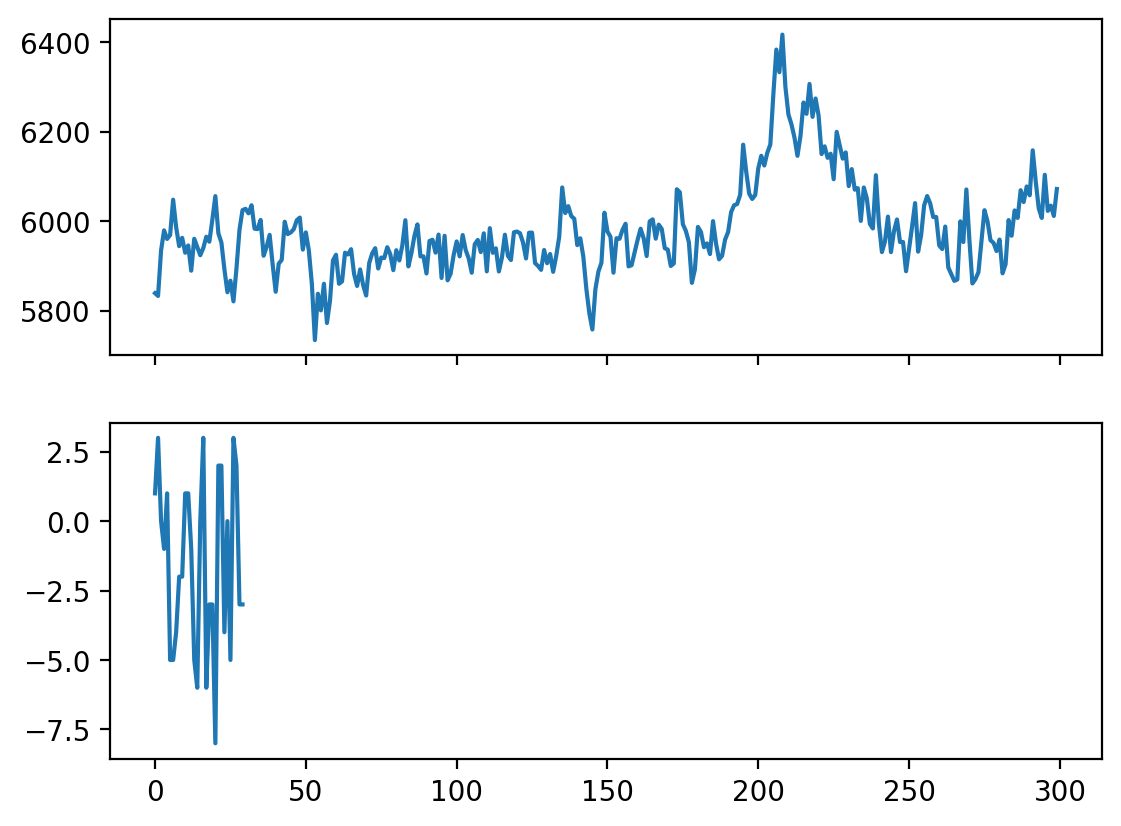

In [15]:
fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(res['S'])
axes[1].plot([np.sum(cpn.topological_charge(cpn_heatbath.wflow(z, dt=0.02, n_step=20))) for z in res['ens'][::10]])
plt.show()

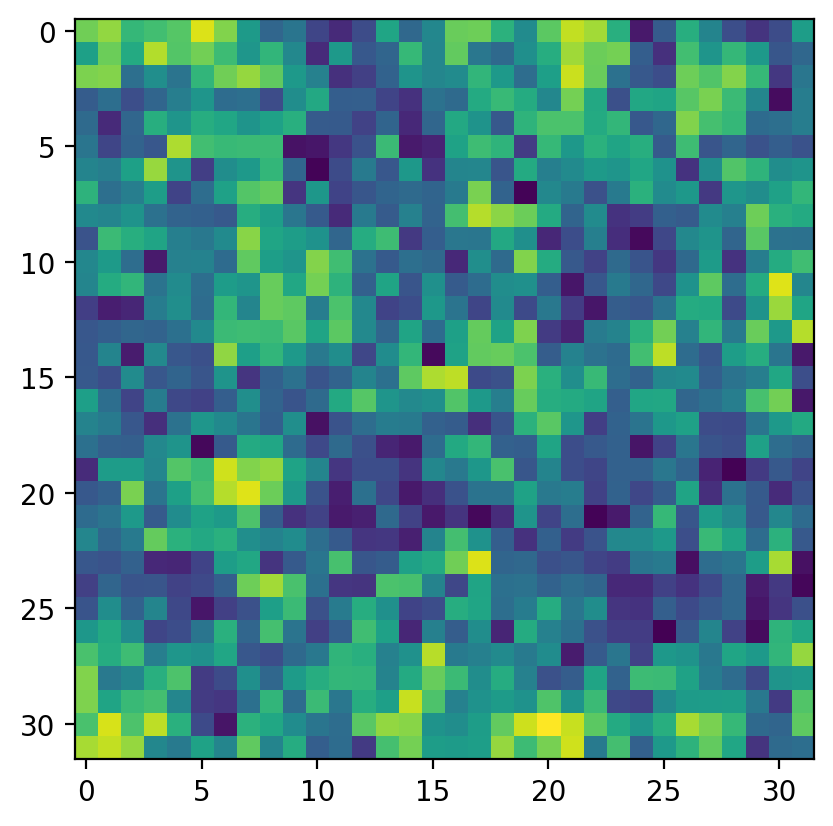

In [7]:
fig, ax = plt.subplots(1, 1)
ax.imshow(np.abs(res['ens'][-1][...,0]))
plt.show()

2.000000000000001


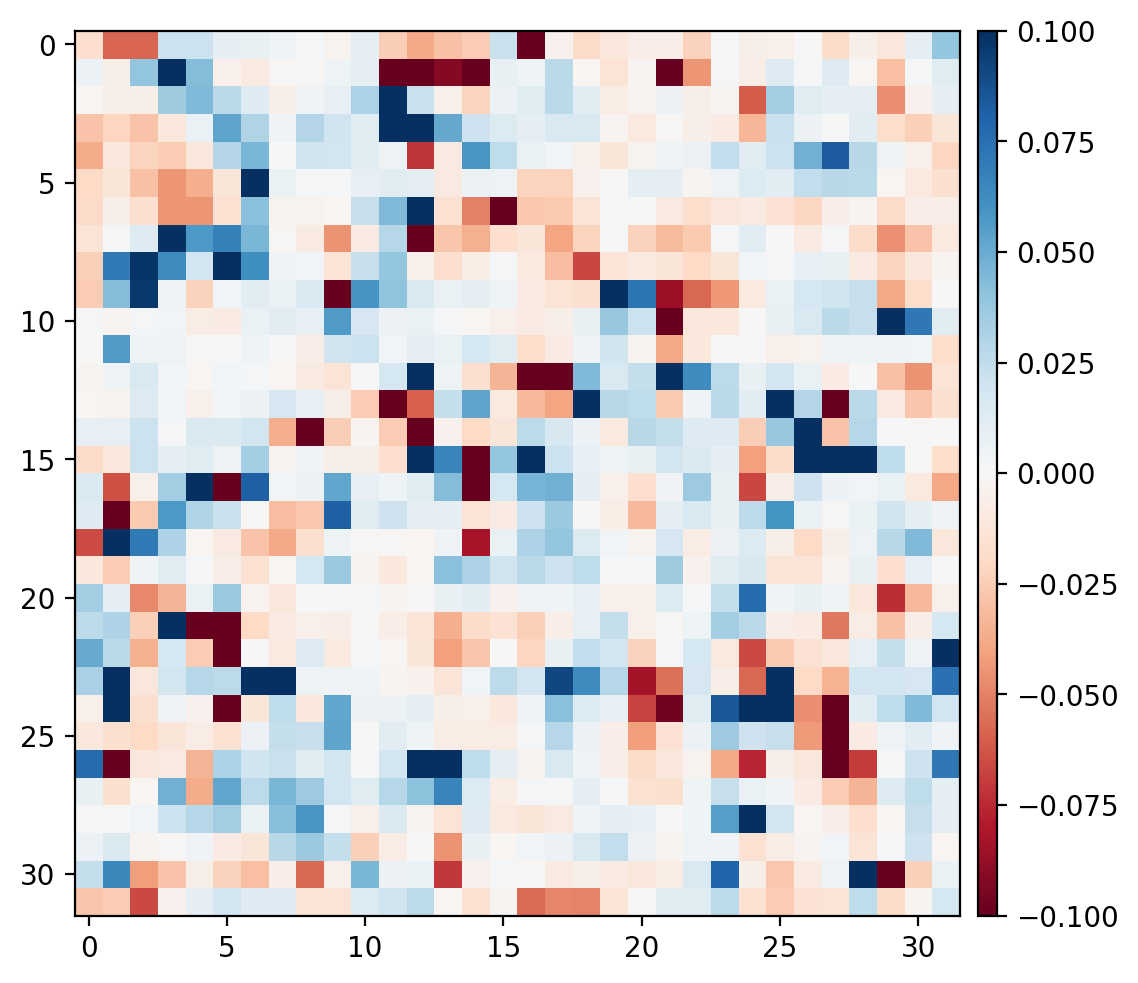

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[0.95, 0.02]), layout='compressed')
ax = axes[0]
cax = axes[1]
z = cpn_heatbath.wflow(res['ens'][1], dt=0.01, n_step=50)
print(np.sum(cpn.topological_charge(z)))
cs = ax.imshow(cpn.topological_charge(z), vmin=-0.10, vmax=0.10, cmap='RdBu')
fig.colorbar(cs, cax=cax)
# z = cpn.make_topo_cfg(shape, 2)
# z = np.pad(z, ((0,0), (0,0), (0,N-2)))
# print(np.sum(cpn.topological_charge(z)))
# ax.imshow(cpn.topological_charge(z))
plt.show()

In [9]:
def build_ising_embedding(z, *, action):
    beta = action.beta
    fz = apply_involution(z)
    # vertical links
    z_up = np.roll(z, -1, axis=0)
    fz_up = np.roll(fz, -1, axis=0)
    A = -beta * (np.abs(cpn.inner(z, z_up))**2 - 1)
    B = -beta * (np.abs(cpn.inner(fz, fz_up))**2 - 1)
    C = -beta * (np.abs(cpn.inner(fz, z_up))**2 - 1)
    D = -beta * (np.abs(cpn.inner(z, fz_up))**2 - 1)
    alpha_v = (A + B - C - D)/4
    beta_v = (A - B - C + D)/4
    gamma_v = (A - B + C - D)/4
    delta_v = (A + B + C + D)/4
    # horizontal links
    z_right = np.roll(z, -1, axis=1)
    fz_right = np.roll(fz, -1, axis=1)
    A = -beta * (np.abs(cpn.inner(z, z_right))**2 - 1)
    B = -beta * (np.abs(cpn.inner(fz, fz_right))**2 - 1)
    C = -beta * (np.abs(cpn.inner(fz, z_right))**2 - 1)
    D = -beta * (np.abs(cpn.inner(z, fz_right))**2 - 1)
    alpha_h = (A + B - C - D)/4
    beta_h = (A - B - C + D)/4
    gamma_h = (A - B + C - D)/4
    delta_h = (A + B + C + D)/4
    # combined magnetization terms
    h = beta_v + beta_h + np.roll(gamma_v, 1, axis=0) + np.roll(gamma_h, 1, axis=1)
    # combined normalization
    d = np.sum(delta_v) + np.sum(delta_h)
    return dict(h=h, J=np.stack((alpha_v, alpha_h)), d=d)

### Simple heatbath sampling
def sample_ising_embedding(embed):
    h, J, d = embed['h'], embed['J'], embed['d']
    shape = h.shape
    s = 2*np.random.randint(0, 1, size=shape) - 1
    mask_par = (np.arange(shape[0])[:,np.newaxis] + np.arange(shape[1])) % 2
    for i in range(10000):
        s_mask = s * mask_par
        up = np.roll(s_mask, -1, axis=0)
        down = np.roll(s_mask, 1, axis=0)
        right = np.roll(s_mask, -1, axis=1)
        left = np.roll(s_mask, 1, axis=1)
        A = (
            J[0] * up + np.roll(J[0], 1, axis=0) * down +
            J[1] * right + np.roll(J[1], 1, axis=1) * left + h
        )
        p = np.exp(-A) / (2*np.cosh(A))
        u = np.random.random(size=shape)
        s[mask_par == 0] = 2*(u < p)[mask_par == 0] - 1
        s_mask = s * (1-mask_par)
        up = np.roll(s_mask, -1, axis=0)
        down = np.roll(s_mask, 1, axis=0)
        right = np.roll(s_mask, -1, axis=1)
        left = np.roll(s_mask, 1, axis=1)
        A = (
            J[0] * up + np.roll(J[0], 1, axis=0) * down +
            J[1] * right + np.roll(J[1], 1, axis=1) * left + h
        )
        p = np.exp(-A) / (2*np.cosh(A))
        u = np.random.random(size=shape)
        s[mask_par == 1] = 2*(u < p)[mask_par == 1] - 1
    action = np.sum((J[0] * np.roll(s, -1, axis=0) + J[1] * np.roll(s, -1, axis=1) + h) * s) + d
    return s, action

def ising_cluster_update(s, J, h):
    s = np.copy(s)
    sv = np.roll(s, -1, axis=0)
    sh = np.roll(s, -1, axis=1)
    p_bond_v = np.where(sv != s, 0.0, 1-np.exp(2*J[0]))
    p_bond_h = np.where(sh != s, 0.0, 1-np.exp(2*J[1]))
    bond_v = np.random.random(size=s.shape) < p_bond_v
    bond_h = np.random.random(size=s.shape) < p_bond_h
    colors = np.arange(s.size).reshape(s.shape)
    while True:
        colors_p = np.copy(colors)
        colors_v = np.roll(colors_p, -1, axis=0)
        colors_p = np.where(bond_v, np.minimum(colors_p, colors_v), colors_p)
        colors_v = np.roll(colors_p, 1, axis=0)
        colors_p = np.where(np.roll(bond_v, 1, axis=0), np.minimum(colors_p, colors_v), colors_p)
        colors_h = np.roll(colors_p, -1, axis=1)
        colors_p = np.where(bond_h, np.minimum(colors_p, colors_h), colors_p)
        colors_h = np.roll(colors_p, 1, axis=1)
        colors_p = np.where(np.roll(bond_h, 1, axis=1), np.minimum(colors_p, colors_h), colors_p)
        if np.all(colors_p == colors):
            break
        colors = colors_p
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(bond_v, cmap='Greys')
    axes[1].imshow(bond_h, cmap='Greys')
    axes[2].imshow(colors)
    for c in np.unique(colors):
        H = np.sum(h[colors == c])
        if H > 100:
            pH = 0.0
        elif H < -100:
            pH = 1.0
        else:
            pH = np.exp(-H)/(2*np.cosh(H))
        # FORNOW:
        pH = 0.5
        spin = 1 if np.random.random() < pH else -1
        s[colors == c] = spin
    return s

### Cluster sampling
def sample_ising_embedding(embed):
    h, J, d = embed['h'], embed['J'], embed['d']
    shape = h.shape
    s = np.ones(shape)
    for i in range(10):
        s = ising_cluster_update(s, J, h)
    action = np.sum((J[0] * np.roll(s, -1, axis=0) + J[1] * np.roll(s, -1, axis=1) + h) * s) + d
    return s, action

def update_via_ising(z, *, action):
    S = action.action(z)
    embed = build_ising_embedding(z, action=action)
    spin, Sp = sample_ising_embedding(embed)
    assert np.all(np.abs(spin) == 1)
    assert spin.shape == z.shape[:-1]
    print(f'{np.sum((spin+1)/2) / spin.size=}')
    fz = apply_involution(z)
    zp = np.where(spin[...,np.newaxis] == 1, z, fz)
    print(f'{S} -> {Sp}')
    assert np.isclose(Sp, action.action(zp)), f'{Sp} vs {action.action(zp)}'
    return zp, spin

np.sum((spin+1)/2) / spin.size=0.3388671875
2526.449368248963 -> 3225.8637633553244


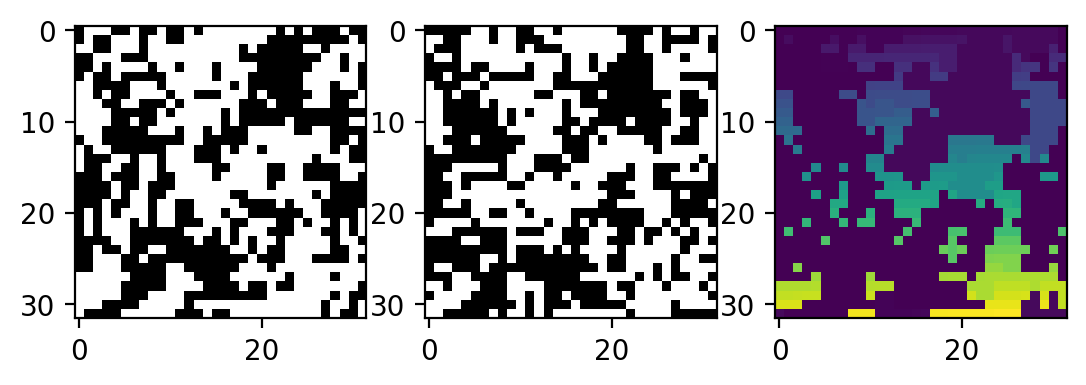

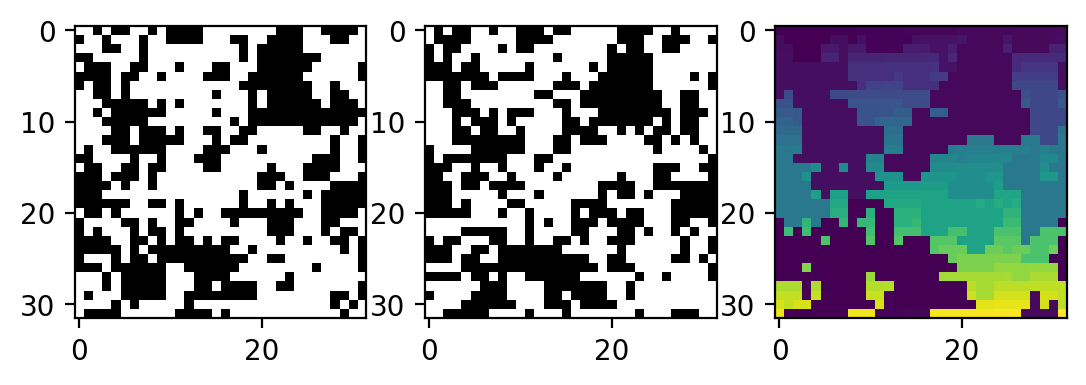

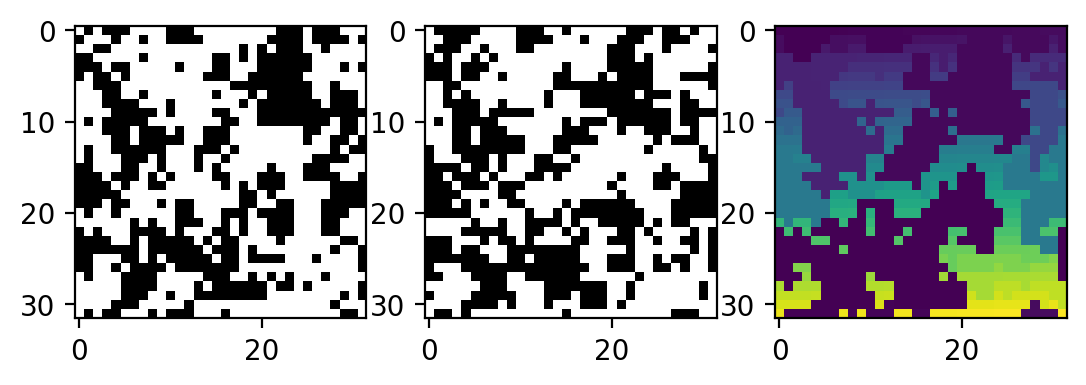

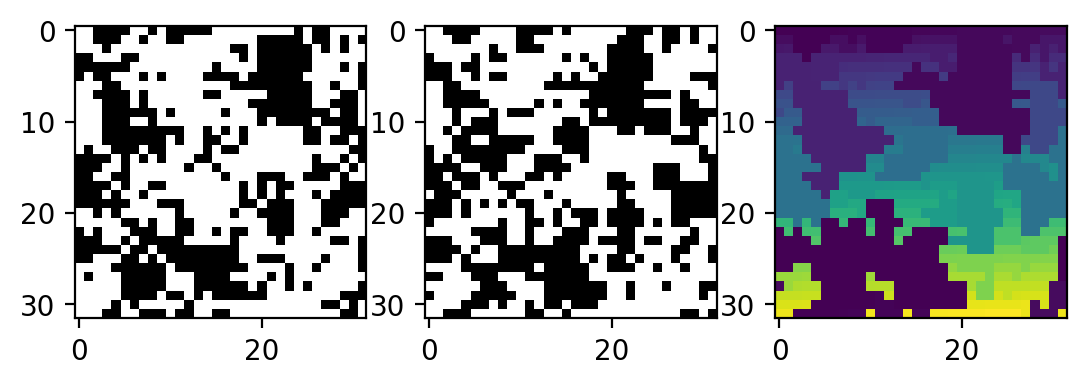

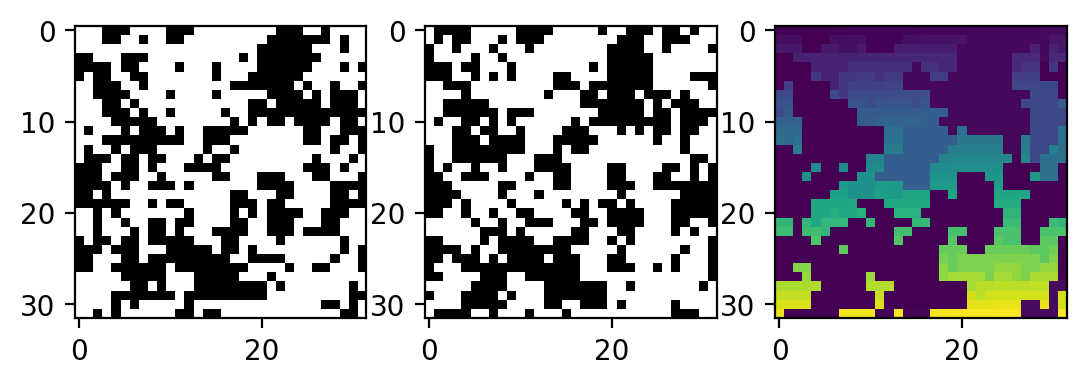

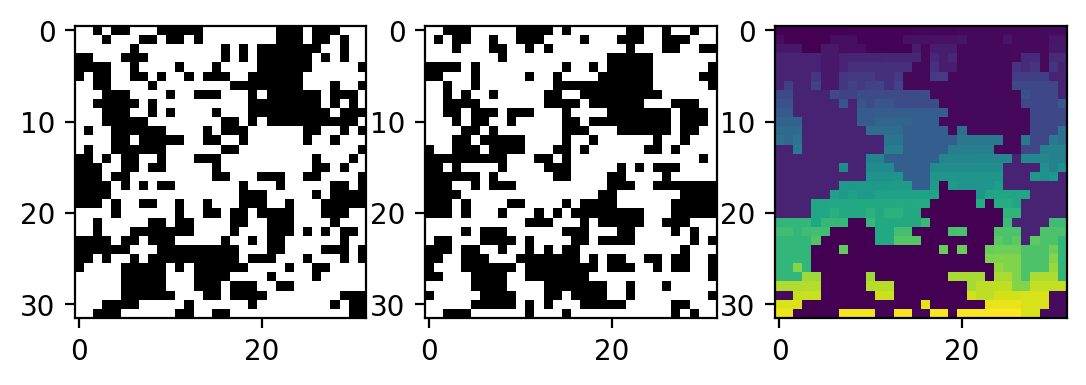

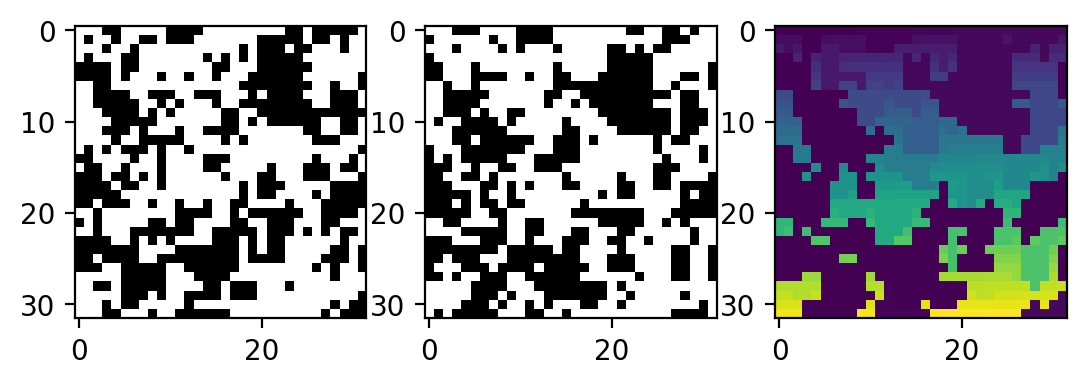

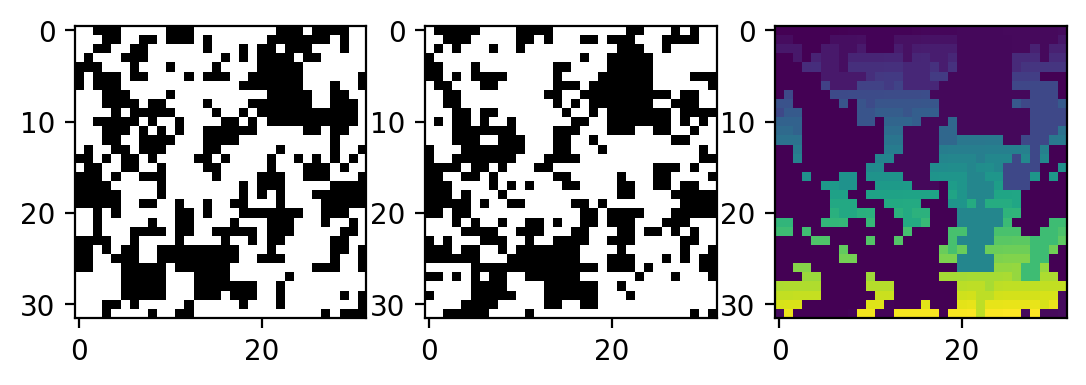

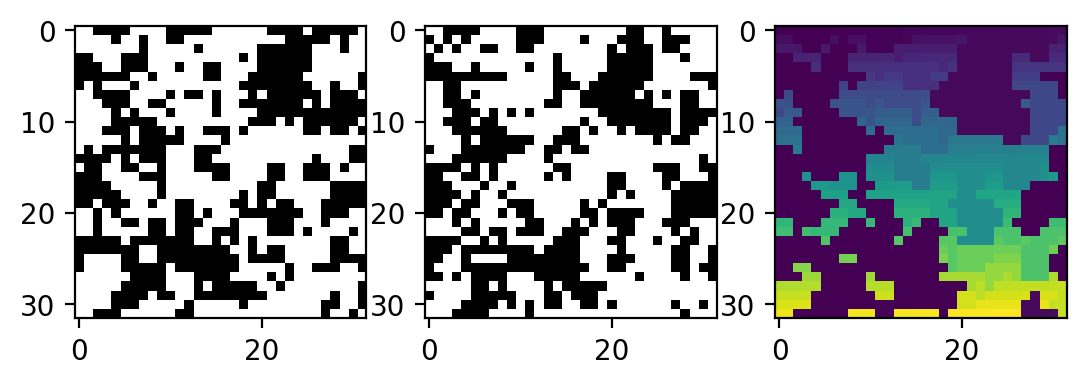

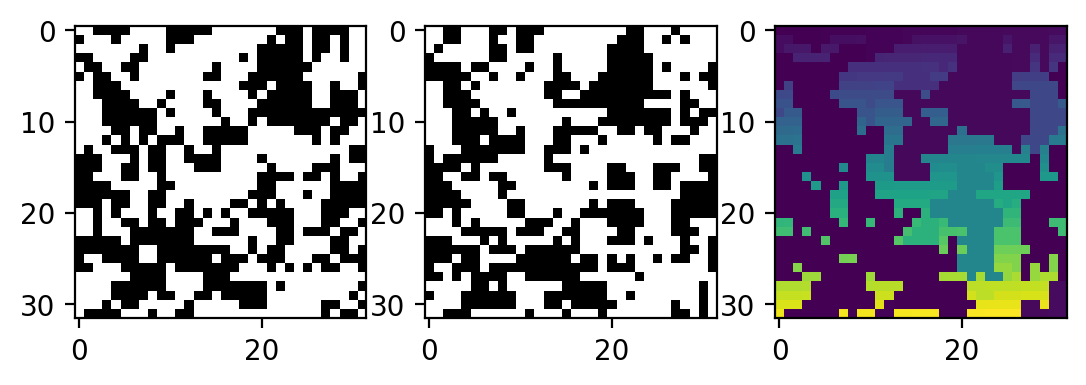

In [10]:
z = cpn_heatbath.wflow(res['ens'][-3], dt=0.02, n_step=20)
embed = build_ising_embedding(z, action=action)
zp, spin = update_via_ising(z, action=action)

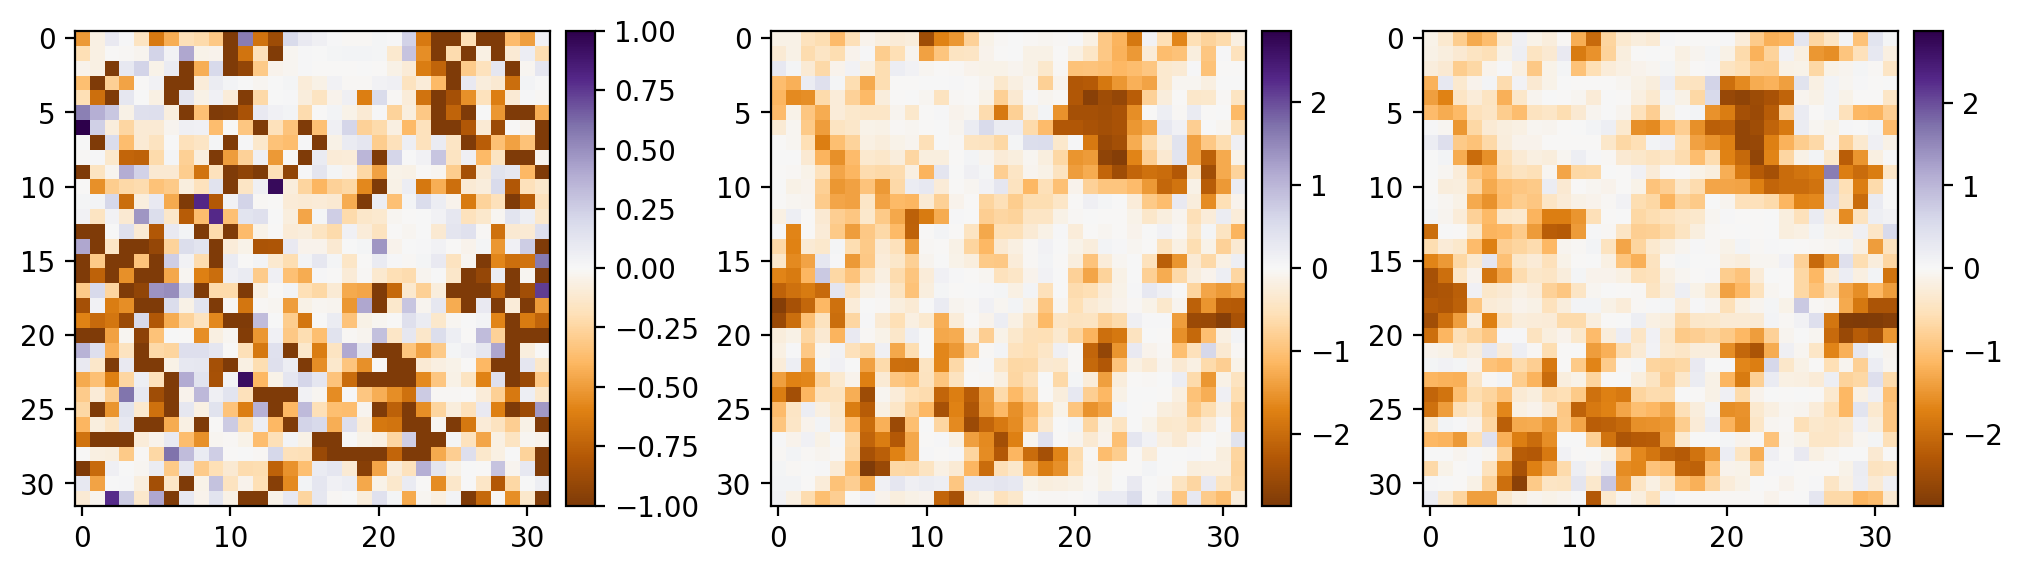

In [11]:
fig, axes = plt.subplots(1,6, gridspec_kw=dict(width_ratios=[0.33, 0.02, 0.33, 0.02, 0.33, 0.02]), layout='compressed', figsize=(10,4))
vmax = 1.0 # np.max(np.abs(embed['h']))
cs = axes[0].imshow(embed['h'], vmin=-vmax, vmax=vmax, cmap='PuOr')
fig.colorbar(cs, cax=axes[1])
vmax = np.max(np.abs(embed['J'][0]))
cs = axes[2].imshow(embed['J'][0], vmin=-vmax, vmax=vmax, cmap='PuOr')
fig.colorbar(cs, cax=axes[3])
vmax = np.max(np.abs(embed['J'][1]))
cs = axes[4].imshow(embed['J'][1], vmin=-vmax, vmax=vmax, cmap='PuOr')
fig.colorbar(cs, cax=axes[5])
plt.show()

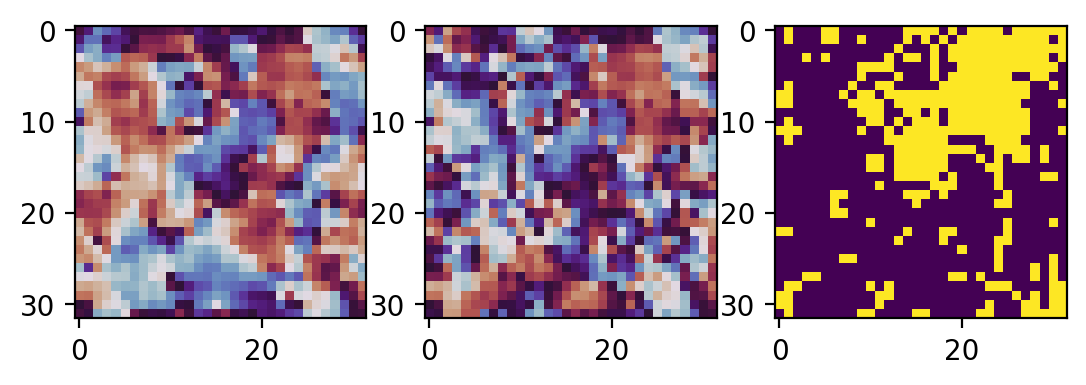

In [12]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.angle(z[...,0]/z[...,-1]), cmap='twilight')
axes[1].imshow(np.angle(zp[...,0]/zp[...,-1]), cmap='twilight')
axes[2].imshow(spin)
plt.show()

-8.881784197001252e-16
-1.0000000000000004


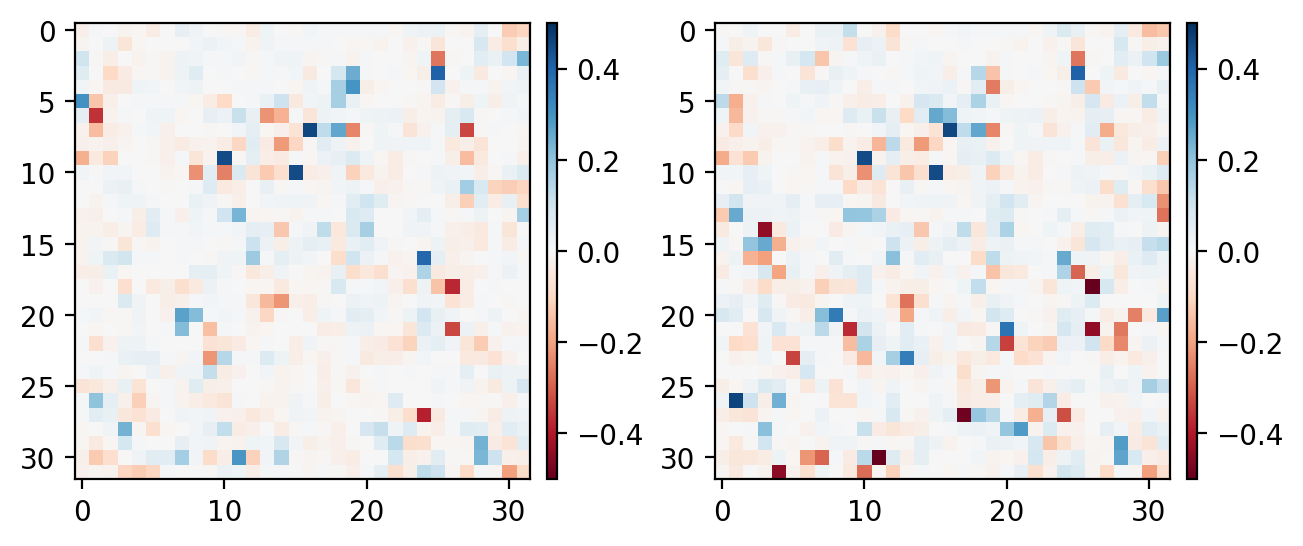

In [17]:
fig, axes = plt.subplots(1, 4, gridspec_kw=dict(width_ratios=[0.95, 0.02, 0.95, 0.02]), layout='compressed')
ax, cax = axes[0:2]
q = cpn.topological_charge(z)
print(np.sum(q))
vmax = 0.50
cs = ax.imshow(q, vmin=-vmax, vmax=vmax, cmap='RdBu')
fig.colorbar(cs, cax=cax)
ax, cax = axes[2:4]
q = cpn.topological_charge(zp)
print(np.sum(q))
cs = ax.imshow(q, vmin=-vmax, vmax=vmax, cmap='RdBu')
fig.colorbar(cs, cax=cax)
# z = cpn.make_topo_cfg(shape, 2)
# z = np.pad(z, ((0,0), (0,0), (0,N-2)))
# print(np.sum(cpn.topological_charge(z)))
# ax.imshow(cpn.topological_charge(z))
plt.show()

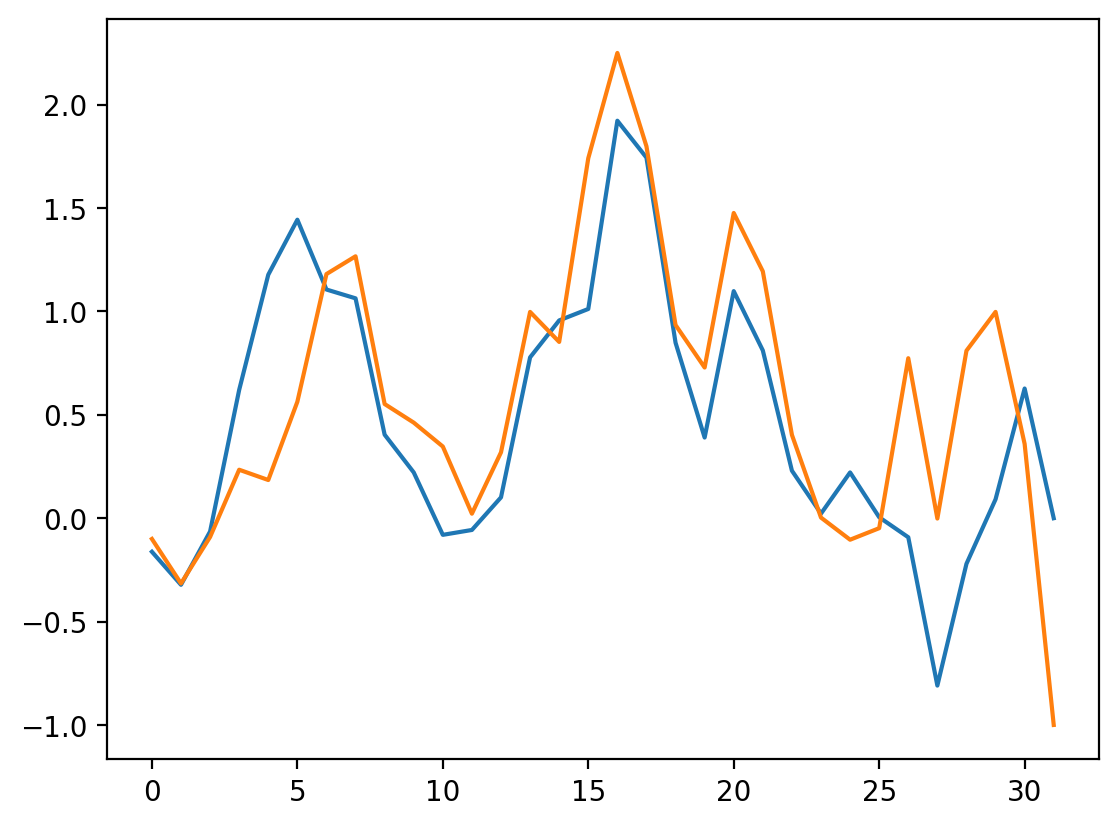

In [14]:
q = cpn.topological_charge(z)
qp = cpn.topological_charge(zp)
plt.plot(np.cumsum(np.sum(q, axis=-1)))
plt.plot(np.cumsum(np.sum(qp, axis=-1)))
plt.show()